In [1]:
import torch
import deepdish as dd

torch.__version__

'1.2.0'

#### load the graph and hard attention for all layers

In [2]:
graph_path = '../../data/botnet/ev10k/chord_no100k_ev10k_us_test.hdf5'
graph_id = 0

atts_path = '../saved_models/botnet_ev10k/chord_lay6_rh1_bs0_hatt_out_nh1_t0.5_ep50_test0-attn.pt'

In [66]:
graph = dd.io.load(graph_path, f'/{graph_id}')
atts = torch.load(atts_path, map_location='cpu')

In [5]:
edge_index = torch.tensor(graph['edge_index'])
x = torch.tensor(graph['x'])
edge_y = torch.tensor(graph['edge_y'])
y = graph['y']

#### check how many selected edges are in the evil community

In [107]:
for i in range(6):
    print((atts[i][edge_y == 1] == 1).sum().item())

6448
8965
9784
9886
9567
9288


In [134]:
edge_mask = torch.tensor(y[edge_index[0]]).bool()
import copy

n_pick_ee = []
for i in range(6):
    b = copy.deepcopy(atts[i])
    b[~edge_mask] = 0
    n_pick_ee.append((b[edge_y == 1] == 1).sum().item())
print(n_pick_ee)

[6448, 8965, 9784, 9886, 9567, 9288]


**Observations**

- so the evil egdes are only picked by the evid nodes
- which means all the normal nodes picked the normal edges
- Among the evil nodes (10000), about 90% picked the evil edges to send info after two layers

#### Mark the edges selected by evil nodes

In [143]:
edge_mask = torch.tensor(y[edge_index[0]]).bool()
import copy

all_b = []
all_edges_mask_ee = torch.zeros(edge_mask.size()).bool()
all_edges_mask = torch.zeros(edge_mask.size()).bool()
n_rec_ee = []
n_rec = []
for i in range(6):
    b = copy.deepcopy(atts[i]).squeeze()
    b[~edge_mask] = 0
    all_b.append(b)
    all_edges_mask_ee = all_edges_mask_ee | (b.bool() & edge_y.bool())
    all_edges_mask = all_edges_mask | b.bool()
    n_rec_ee.append(all_edges_mask_ee.sum().item())
    n_rec.append(all_edges_mask.sum().item())
print(n_rec_ee)
print(n_rec)

[6448, 13690, 20103, 25537, 28007, 29725]
[10000, 18181, 24787, 30255, 33097, 35407]


In [138]:
all_edges_mask.sum()

tensor(29725)

In [139]:
edge_y.sum()

tensor(49566)

#### draw some plots

In [144]:
import matplotlib.pyplot as plt

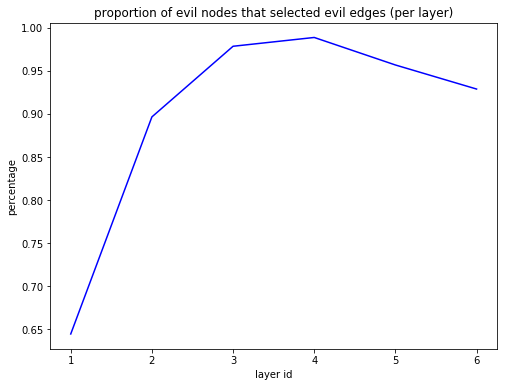

In [185]:
# proportion of edges that are evil among all edges that are chosen by evil nodes in every layer
plt.figure(figsize=(8, 6))
plt.plot([i + 1 for i in range(6)], [n/10000 for n in n_pick_ee], 'b-')
plt.xlabel('layer id')
plt.ylabel('percentage')
plt.title('proportion of evil nodes that selected evil edges (per layer)')
plt.savefig('evil_edge1.png')
plt.show()

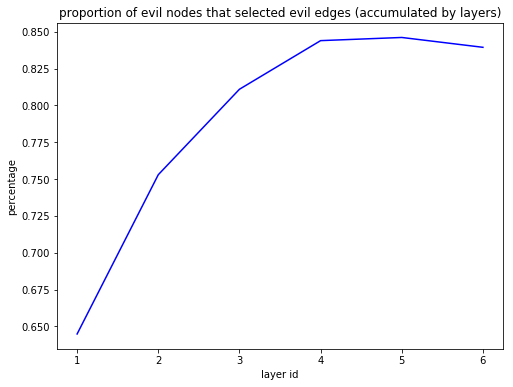

In [186]:
# proportion of edges that are evil among all edges that are chosen by evil nodes accumulated with layers
plt.figure(figsize=(8, 6))
plt.plot([i + 1 for i in range(6)], [n/m for n, m in zip(n_rec_ee, n_rec)], 'b-')
plt.xlabel('layer id')
plt.ylabel('percentage')
plt.title('proportion of evil nodes that selected evil edges (accumulated by layers)')
plt.savefig('evil_edge2.png')
plt.show()

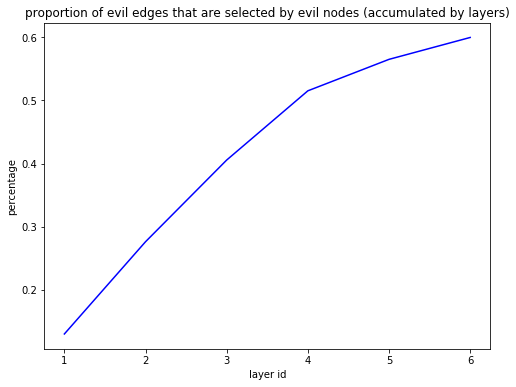

In [187]:
# proportion of evil edges that are recovered by selection of evil nodes
plt.figure(figsize=(8, 6))
plt.plot([i + 1 for i in range(6)], [n/edge_y.sum().item() for n in n_rec_ee], 'b-')
plt.xlabel('layer id')
plt.ylabel('percentage')
plt.title('proportion of evil edges that are selected by evil nodes (accumulated by layers)')
plt.savefig('evil_edge3.png')
plt.show()

#### check edges that are connected to evil nodes 

In [173]:
evil_node_edge_mask = torch.tensor(y[edge_index[0]])

In [177]:
evil_node_edge_mask[edge_y == 1].sum()

tensor(49566)

In [178]:
edge_y.sum()

tensor(49566)

In [179]:
evil_node_edge_mask.sum()

tensor(153243)

In [180]:
evil_node_edge_mask1 = torch.tensor(y[edge_index[1]])

In [184]:
(evil_node_edge_mask1 & evil_node_edge_mask).sum()

tensor(49566)